In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn 
from torchmetrics import Accuracy
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
import seaborn as sns
import plotly.express as px
import warnings
from PIL import Image
from torchvision.transforms import v2
import random

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

# Loading & processing Data

In [3]:
data_path = os.path.join(os.getcwd(), "data")
metadata_path = os.path.join(data_path, "HAM10000_metadata.csv")
skin_cancer_df = pd.read_csv(metadata_path)

In [4]:
images_folders = [
    os.path.join(data_path, "HAM10000_images_part_1"),
    os.path.join(data_path, "HAM10000_images_part_2")
    ]

**Creating a dictionary of image paths to add to the metadata dataframe**

In [5]:
images_path_dict = {}
for folder in images_folders:
    for image in os.listdir(folder):
        images_path_dict[image.replace(".jpg", "")] = os.path.join(folder, image)

More user friendly cell-type diagnosis

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
skin_cancer_df["dx_expanded"] = skin_cancer_df["dx"].map(lesion_type_dict)
skin_cancer_df["dx_idx"] = pd.Categorical(skin_cancer_df["dx_expanded"]).codes
skin_cancer_df["image_path"] = skin_cancer_df.image_id.map(images_path_dict)

In [8]:
skin_cancer_df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                      dx_expanded  dx_idx  \
0  Benign keratosis-like lesions        2   
1  Benign keratosis-like lesions        2   
2  Benign keratosis-like lesions        2   
3  Benign keratosis-like lesions        2   
4  Benign keratosis-like lesions        2   

                                          image_path  
0  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
1  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
2  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
3  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
4  C:\Users\Nichita\PycharmProjects\ResNetFromScr...

# Data cleaning

In [9]:
skin_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dx_expanded   10015 non-null  object 
 8   dx_idx        10015 non-null  int8   
 9   image_path    10015 non-null  object 
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [10]:
skin_cancer_df.isnull().sum().sort_values(ascending=False)

age             57
lesion_id        0
image_id         0
dx               0
dx_type          0
sex              0
localization     0
dx_expanded      0
dx_idx           0
image_path       0
dtype: int64

In [11]:
skin_cancer_df["age"] = skin_cancer_df["age"].fillna(skin_cancer_df["age"].median())

In [12]:
skin_cancer_df.isnull().sum().sort_values(ascending=False)

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dx_expanded     0
dx_idx          0
image_path      0
dtype: int64

In [13]:
skin_cancer_df["age"] = skin_cancer_df["age"].astype("int")

# EDA

In [14]:
skin_cancer_df.dx_type.value_counts()

dx_type
histo        5340
follow_up    3704
consensus     902
confocal       69
Name: count, dtype: int64

In [15]:
skin_cancer_df.head(10)

lesion_id      image_id   dx dx_type  age     sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80    male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80    male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo   80    male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo   80    male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo   75    male          ear   
5  HAM_0001466  ISIC_0027850  bkl   histo   75    male          ear   
6  HAM_0002761  ISIC_0029176  bkl   histo   60    male         face   
7  HAM_0002761  ISIC_0029068  bkl   histo   60    male         face   
8  HAM_0005132  ISIC_0025837  bkl   histo   70  female         back   
9  HAM_0005132  ISIC_0025209  bkl   histo   70  female         back   

                      dx_expanded  dx_idx  \
0  Benign keratosis-like lesions        2   
1  Benign keratosis-like lesions        2   
2  Benign keratosis-like lesions        2   
3  Benign keratosis-like lesions        2   
4  Benign keratosis-like lesions        2   
5  Benign keratosis-like lesions        2   
6  Benign keratosis-like lesions        2   
7  Benign keratosis-like lesions        2   
8  Benign keratosis-like lesions        2   
9  Benign keratosis-like lesions        2   

                                          image_path  
0  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
1  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
2  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
3  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
4  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
5  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
6  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
7  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
8  C:\Users\Nichita\PycharmProjects\ResNetFromScr...  
9  C:\Users\Nichita\PycharmProjects\ResNetFromScr...

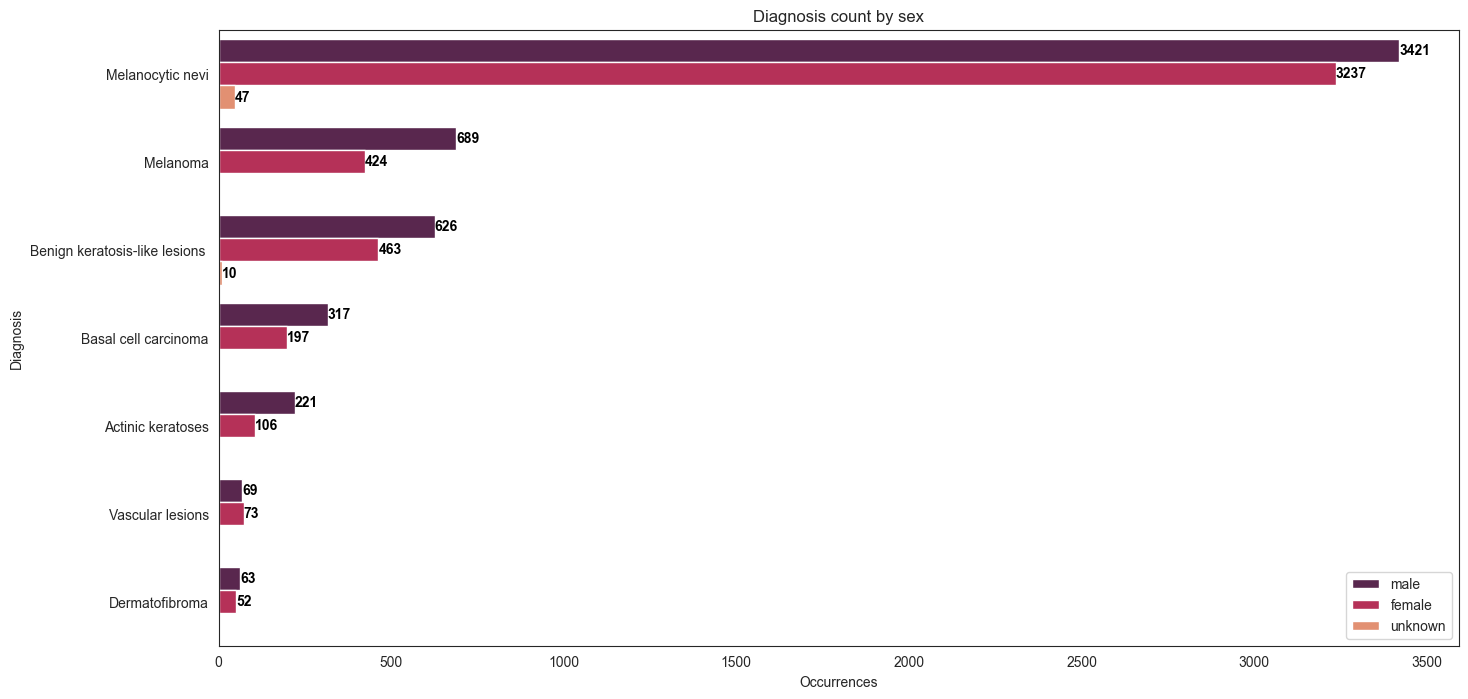

In [16]:
sns.set_style("white")
rocket_cpal_15 = sns.color_palette("rocket", 15)
rocket_cpal_3 = sns.color_palette("rocket", 3)
type_order_sorter = skin_cancer_df["dx_expanded"].value_counts().index
local_order_sorter = skin_cancer_df["localization"].value_counts().index
plt.figure(figsize=(16,8))
ax = sns.countplot(data=skin_cancer_df, y="dx_expanded", hue="sex", palette=rocket_cpal_3, order=type_order_sorter)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontweight="bold", label_type="edge", color="black")
plt.xlabel("Occurrences")
plt.ylabel("Diagnosis")
plt.title("Diagnosis count by sex")
plt.legend()
plt.show()

In [17]:
plt.figure(figsize=(16,8))
ax = sns.countplot(data=skin_cancer_df, y="localization", hue="localization", palette=rocket_cpal_15, order=local_order_sorter)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontweight="bold", label_type="edge", color="black")
plt.xlabel("Occurrences")
plt.ylabel("Localization")
plt.title("Number of cases by localization")
plt.show()

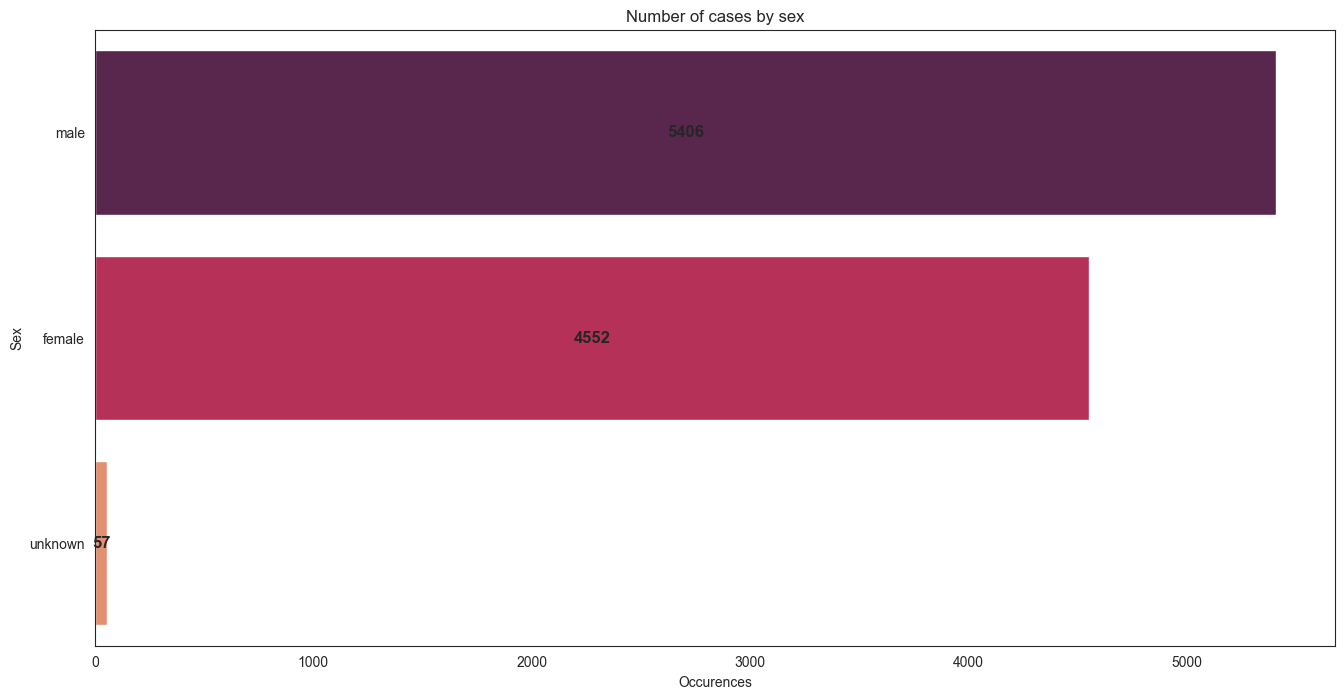

In [18]:
plt.figure(figsize=(16,8))
ax = sns.countplot(skin_cancer_df, y="sex", hue="sex", palette=rocket_cpal_3)
for container in ax.containers:
    ax.bar_label(container, fontweight="bold", label_type="center", fontsize=12)
plt.xlabel("Occurences")
plt.ylabel("Sex")
plt.title("Number of cases by sex")
plt.show()

In [19]:
malign_conditions = ["Melanoma", "Basal cell carcinoma", "Actinic keratoses"]
skin_cancer_df["Malign"] = np.where(skin_cancer_df["dx_expanded"].isin(malign_conditions), 1, 0)

In [20]:
skin_cancer_df[skin_cancer_df.Malign == 1].dx_expanded.value_counts()

dx_expanded
Melanoma                1113
Basal cell carcinoma     514
Actinic keratoses        327
Name: count, dtype: int64

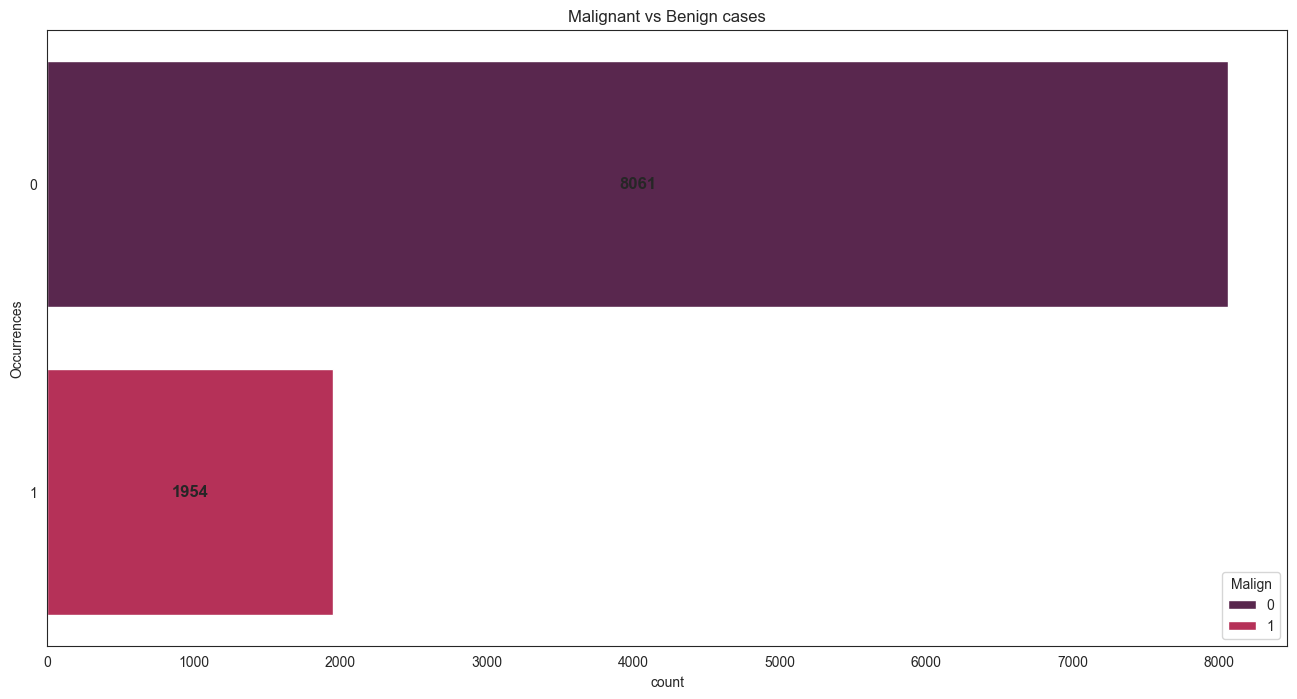

In [21]:
plt.figure(figsize=(16,8))
ax = sns.countplot(data=skin_cancer_df, y="Malign", hue="Malign", palette=rocket_cpal_3[:2])
for container in ax.containers:
    ax.bar_label(container, fontweight="bold", label_type="center", fontsize=12)
plt.ylabel("Occurrences")
plt.title("Malignant vs Benign cases")
plt.show()

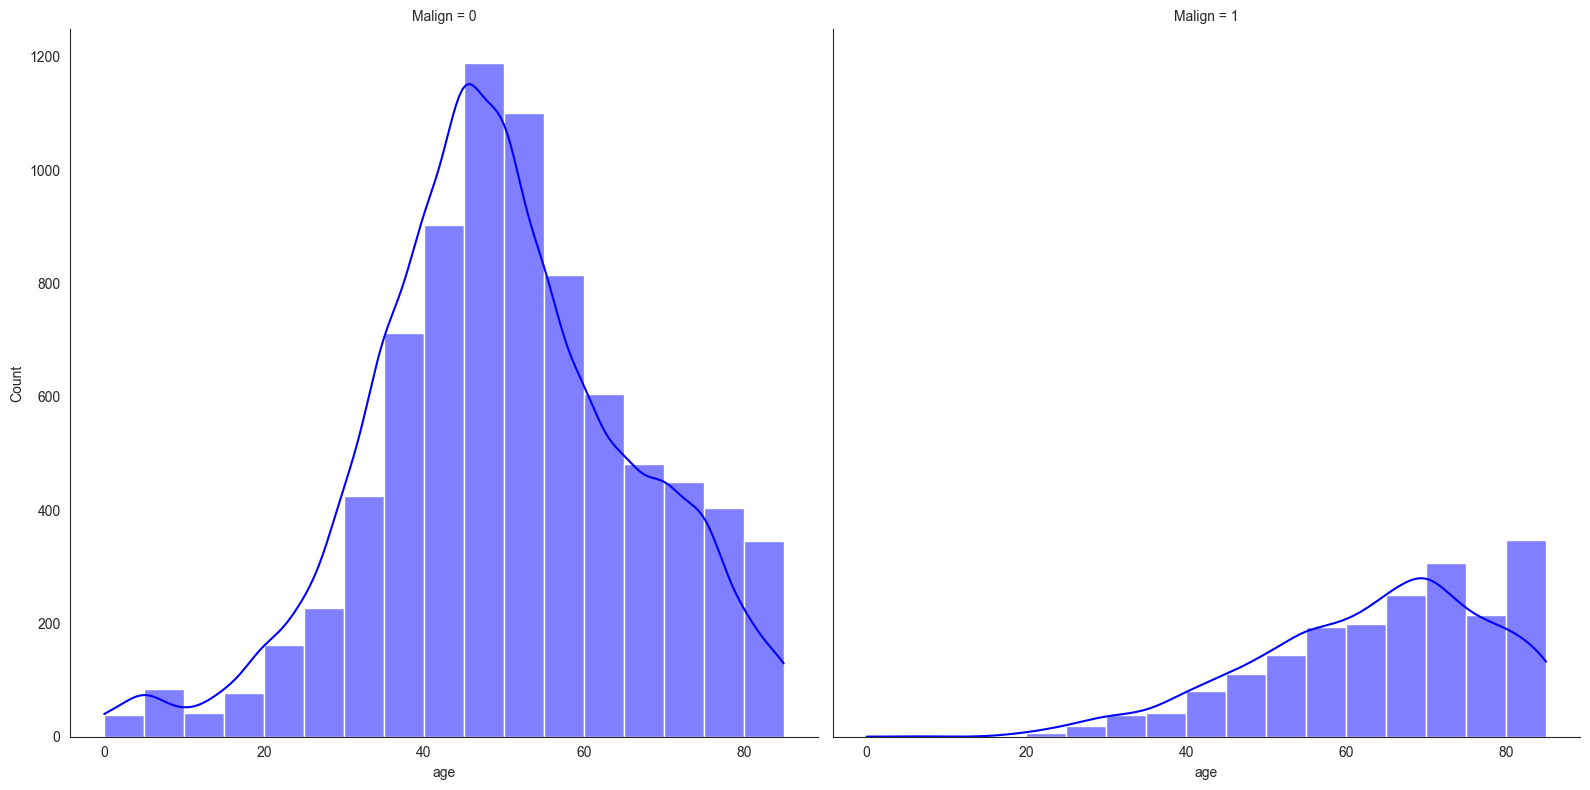

In [22]:
sns.displot(data=skin_cancer_df, x="age", binwidth=5, col="Malign", kind='hist', kde=True, color="blue", aspect=1, height=8)
plt.show()

In [23]:
skin_cancer_df["diag_as_text"] = np.where(skin_cancer_df["Malign"]==1, "Malign", "Benign")

In [24]:
fig = px.treemap(data_frame=skin_cancer_df,
                 path=["diag_as_text", "sex", "dx_expanded"],
                 color="diag_as_text",
                 color_discrete_map={"Malign":"red", "Benign":"green"},
                 height=800, 
                 width=1500)
fig.show()

# DataLoader / CustomDataset

**Split data in train, validation, test datasets**

In [25]:
class HAM10kCustom(Dataset):
    def __init__(self, images, image_labels, transform=None):
        self.X = images.reset_index(drop=True)
        self.y = image_labels.reset_index(drop=True)
        self.classes = np.unique(y)
        self.transform = transform
        self.classes_to_idx = {label:label_idx for label, label_idx in zip(labels, list(range(len(labels))))}
    
    def load_image(self, index):
        """Opens an image via a path and returns it."""
        image_path = self.X[index]
        return Image.open(image_path)
    
    def __len__(self):
        """Returns the total number of samples."""
        return len(self.X)
    
    
    def __getitem__(self, index):
        """Retrieves an image and its corresponding class index from the dataset."""
        img = self.load_image(index)
        class_name = self.y[index]
        class_idx = self.classes_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [26]:
def display_random_images(dataset, classes, n=5, display_shape=False, seed=None):
    if n > 5:
        n = 5
        display_shape = False
        print(f"For display purposes n shouldn't be greater than 5. Setting n to 5")
        print(f"For values greater than 5 call the function n//5 times adjusting n subsequently.")
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16,8))
    for i, target_sample in enumerate(random_samples_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        # target_image_transform = v2.Compose([
        #     v2.ToImage(),
        #     v2.ToDtype(torch.float32, scale=True)
        # ])
        # target_image = target_image_transform(target_image)
        target_image_adjust = target_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title += f"\nshape: {target_image_adjust.shape}"
            plt.title(title)
    plt.show()

In [28]:
X = skin_cancer_df["image_path"]
y = skin_cancer_df["dx_expanded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [29]:
labels = list(np.unique(y))
labels_to_idx = {label:idx for label, idx in zip(labels, list(range(len(labels))))}

In [30]:
train_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.4),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
    # v2.ToTensor()
])

In [31]:
test_transforms = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
    # v2.ToTensor()
])

In [32]:
train_data = HAM10kCustom(X_train, y_train, train_transforms)
val_data = HAM10kCustom(X_val, y_val, test_transforms)
test_data = HAM10kCustom(X_test, y_test, test_transforms)

For display purposes n shouldn't be greater than 5. Setting n to 5
For values greater than 5 call the function n//5 times adjusting n subsequently.


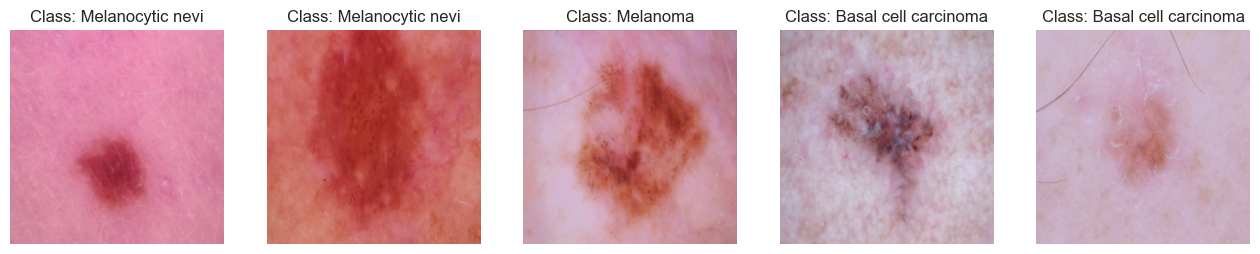

In [33]:
display_random_images(train_data, n=6, classes=list(train_data.classes), display_shape=False)

In [34]:
BATCH_SIZE = 32
NUM_WORKERS = 0
train_custom_dataloader = DataLoader(dataset=train_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

val_custom_dataloader = DataLoader(dataset=val_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

test_custom_dataloader = DataLoader(dataset=test_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [35]:
img_custom, label_custom = next(iter(train_custom_dataloader))

In [36]:
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# Baseline model
We're going to build and use TinyVGG as a baseline model

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device_:torch.device="cpu",
               compute_accuracy:bool=True):
    model.train()
    train_loss, train_acc = 0, 0 if compute_accuracy else None
    for batch, (X_, y_) in enumerate(dataloader):
        X_, y_ = X_.to(device_), y_.to(device_)
        y_pred = model(X_)

        loss = loss_function(y_pred, y_)
        train_loss += loss.item()

        if compute_accuracy:
            accuracy_fn = Accuracy(task="multiclass",
                                   num_classes=len(train_data.classes)).to(device_)
            train_acc += accuracy_fn(y_pred, y_)



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               compute_accuracy:bool=True,
               device_:torch.device="cpu"):

    model.eval()
    test_loss, test_acc = 0, 0 if compute_accuracy else None
    with torch.inference_mode():
        for batch, (X_, y_) in enumerate(dataloader):
            X_, y_ = X_.to(device_), y_.to(device_)

            test_preds = model(X_)

            loss = loss_function(test_preds, y_)
            test_loss += loss.item()

            if compute_accuracy:
                accuracy_fn = Accuracy(task="multiclass",
                                   num_classes=len(train_data.classes)).to(device_)
                test_acc += accuracy_fn(test_preds, y_)

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc